In [19]:
from google.colab import auth
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, roc_auc_score, roc_curve, 
                             confusion_matrix, f1_score, precision_score, 
                             recall_score)

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer


## Loading Data


In [20]:
auth.authenticate_user()

#### Lab Data

In [21]:
!gsutil cp gs://mlhc-mimic/adult_icu.gz ./


Copying gs://mlhc-mimic/adult_icu.gz...
/ [1 files][  3.1 MiB/  3.1 MiB]                                                
Operation completed over 1 objects/3.1 MiB.                                      


In [22]:
lab_df = pd.read_csv('adult_icu.gz')

#### Note Data

In [23]:
!gsutil cp gs://mlhc-mimic/adult_notes.gz ./


Copying gs://mlhc-mimic/adult_notes.gz...
-
Operation completed over 1 objects/76.6 MiB.                                     


In [24]:
note_df = pd.read_csv('adult_notes.gz')

## Question 2

Predicting hospital mortality from lab values



In [25]:
##Explore the dataset lab_df

In [26]:
len(lab_df)

27348

In [27]:
lab_df["hadm_id"].nunique()

25809

In [28]:
lab_df["subject_id"].nunique()

21376

In [29]:
##Dropping features
lab_df.drop(["subject_id","hadm_id","icustay_id", "mort_icu", "mort_oneyr", "adult_icu", "admType_NEWBORN"], axis=1, inplace=True)

In [30]:
##Split the dataset into train/val/test. Note that we have already provided
##the columns "train", "test", "valid" for you which splits the dataset into 
##training set, validation set and testing set. 
##Once you're done, remove the columns train, val and test from the dataset. 

In [31]:
training_data = lab_df[lab_df["train"] == 1].drop(columns=["train", "test", "valid"])
validation_data = lab_df[lab_df["valid"] == 1].drop(columns=["train", "test", "valid"])
test_data = lab_df[lab_df["test"] == 1].drop(columns=["train", "test", "valid"])

In [32]:
print(len(training_data))
print(len(validation_data))
print(len(test_data))

16401
5448
5499


In [33]:
train_X, train_y = training_data.drop(columns=["mort_hosp"]), training_data["mort_hosp"]
valid_X, valid_y = validation_data.drop(columns=["mort_hosp"]), validation_data["mort_hosp"]
test_X, test_y = test_data.drop(columns=["mort_hosp"]), test_data["mort_hosp"]

In [34]:
sum(train_y.values) / len(train_y)

0.13962563258337907

In [35]:
##Normalize the data in train/val/test. Be sure to fit StandardScaler to the training dataset only! 

In [36]:
pipeline = Pipeline(
    [("num_standardizer", StandardScaler()),
     ("clf", LogisticRegression(solver='liblinear', max_iter=2000, verbose=2))
     ]
)

In [37]:
##Problem 2.5, 2.6 - Train a Logistic Regression model (with solver = 'libnear') to predict mortality given the remaining features available. 

C = [0.1, 0.25, 1]
penalty = ['l1', 'l2']

In [38]:
for c_val in C:
  for penalty_val in penalty:
    pipeline.set_params(clf__C = c_val, clf__penalty = penalty_val)
    pipeline.fit(train_X, train_y)
    print(f"c = {c_val}, penalty = {penalty_val}")
    print(pipeline.score(valid_X, valid_y))

[LibLinear]c = 0.1, penalty = l1
0.86068281938326
[LibLinear]c = 0.1, penalty = l2
0.86068281938326
[LibLinear]c = 0.25, penalty = l1
0.86068281938326
[LibLinear]c = 0.25, penalty = l2
0.8610499265785609
[LibLinear]c = 1, penalty = l1
0.8608663729809104
[LibLinear]c = 1, penalty = l2
0.8612334801762115


In [39]:
pipeline.set_params(clf__C = 1, clf__penalty = 'l2')
pipeline.fit(train_X, train_y)

[LibLinear]

Pipeline(memory=None,
         steps=[('num_standardizer',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=2000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=2,
                                    warm_start=False))],
         verbose=False)

In [40]:
pipeline.score(test_X, test_y)

0.8663393344244408

In [41]:
standardizer = pipeline['num_standardizer']
model = pipeline['clf']

In [42]:
test_X_standardized = standardizer.transform(test_X)
predicted_values = model.predict(test_X_standardized)

In [43]:
accuracy_score(test_y, predicted_values)

0.8663393344244408

In [44]:
roc_auc_score(test_y, predicted_values)

0.5672897832285055

In [45]:
confusion_matrix(test_y, predicted_values)

array([[4647,   85],
       [ 650,  117]])

In [46]:
print(precision_score(test_y, predicted_values))
print(recall_score(test_y, predicted_values))

0.5792079207920792
0.15254237288135594


In [47]:
##Problem 2.7 - Which of the following features are among the top 5 most 
##positive features, based on the coefficients of the logistic regression model?

In [48]:
feature_importances = zip(train_X.columns, *model.coef_)
print(sorted(list(feature_importances), key=lambda x: -x[1]))

[('glucose_mean', 1.3988387987531652), ('hematocrit', 0.3724188486223247), ('meanbp_mean', 0.3124986802117846), ('age', 0.28842747013215425), ('tempc_max', 0.2578131159535194), ('bilirubin', 0.25187778445448694), ('heartrate_mean', 0.20973036598533912), ('resprate_mean', 0.19721927900968972), ('bun', 0.18770696006742882), ('lactate', 0.17593653292290357), ('admType_EMERGENCY', 0.17495664714110107), ('aniongap', 0.15241454832767068), ('sodium', 0.13256042705737098), ('eth_other', 0.12866211977289466), ('heartrate_max', 0.12293532629721131), ('glucose_min', 0.08481316871320269), ('wbc', 0.060657635778060735), ('resprate_min', 0.05882339578059446), ('diasbp_min', 0.05575969911324497), ('sysbp_max', 0.05563247318250804), ('spo2_max', 0.038975080777296084), ('phosphate', 0.03275619464894038), ('pt', 0.023460669701890185), ('admType_URGENT', 0.022761781576675494), ('resprate_max', 0.01830020236045261), ('potassium', 0.005412252328945948), ('eth_asian', 0.0027637046630458345), ('inr', 0.00074

In [49]:
##Problem 2.8 - Which of the following features are among the top 5 most 
##negative features, based on the coefficients of the logistic regression model?

In [50]:
feature_importances = zip(train_X.columns, *model.coef_)
print(sorted(list(feature_importances), key=lambda x: x[1]))

[('glucose_max', -1.4162911992260383), ('hemoglobin', -0.494153633447963), ('diasbp_mean', -0.2947824572456773), ('tempc_mean', -0.28021842623876675), ('sysbp_min', -0.23526443302166472), ('platelet', -0.21152678716079537), ('albumin', -0.20645203593478284), ('admType_ELECTIVE', -0.1998868348233678), ('chloride', -0.16067382197222588), ('creatinine', -0.11921520681364121), ('eth_black', -0.10251304211809605), ('first_icu_stay', -0.0951347108157934), ('spo2_min', -0.0882273805247778), ('tempc_min', -0.0822625856116285), ('heartrate_min', -0.07754918021498901), ('meanbp_min', -0.07053927024345387), ('diasbp_max', -0.06127293261612552), ('sysbp_mean', -0.05306227428713545), ('glucose', -0.05189963480117162), ('spo2_mean', -0.04503178778087107), ('first_hosp_stay', -0.039683011711246705), ('bicarbonate', -0.031617994995189726), ('eth_hispanic', -0.03110763924255103), ('magnesium', -0.02314009223103917), ('eth_white', -0.020987654428867134), ('meanbp_max', -0.007537286956993679), ('ptt', -0

## Question 3

Predicting hospital mortality from clinical notes


In [51]:
len(note_df)

15000

In [52]:
note_df.drop(["subject_id","hadm_id","icustay_id", "mort_icu", "mort_oneyr"], axis=1, inplace=True)

In [53]:
note_df.columns

Index(['chartext', 'train', 'mort_hosp', 'test', 'valid'], dtype='object')

In [54]:
##Split the dataset into train/val/test

In [55]:
training_data = note_df[note_df["train"] == 1].drop(columns=["train", "test", "valid"])
validation_data = note_df[note_df["valid"] == 1].drop(columns=["train", "test", "valid"])
test_data = note_df[note_df["test"] == 1].drop(columns=["train", "test", "valid"])

In [56]:
print(len(training_data))
print(len(validation_data))
print(len(test_data))

9039
3046
2915


In [57]:
train_X, train_y = training_data["chartext"].values, training_data["mort_hosp"].values
valid_X, valid_y = validation_data["chartext"].values, validation_data["mort_hosp"].values
test_X, test_y = test_data["chartext"].values, test_data["mort_hosp"].values

In [58]:
##Fit a CountVectorizer with max_features = 5000 to the trianing dataset and generate features for train/val/test. 
vectorizer = CountVectorizer(max_features = 5000)

In [59]:
pipeline = Pipeline([
                     ("vectorizer", vectorizer),
                     ("clf", LogisticRegression(solver='liblinear', max_iter=2000))
])

In [60]:
##Problem 3.1, 3.2 Train a Logistic Regression model (with solver = 'liblinear') to predict mortality given the remaining features available. 

C = [0.1,0.25,1]
penalty = ['l1','l2']
for c_val in C:
  for penalty_val in penalty:
    print(f"using C = {c_val}, penalty = {penalty_val}")
    pipeline.set_params(clf__C = c_val, clf__penalty = penalty_val)
    pipeline.fit(train_X, train_y)
    print(f"validation accuracy = {pipeline.score(valid_X, valid_y)}")

using C = 0.1, penalty = l1
validation accuracy = 0.8539067629678266
using C = 0.1, penalty = l2
validation accuracy = 0.8355219960604071
using C = 0.25, penalty = l1
validation accuracy = 0.8437294812869337
using C = 0.25, penalty = l2
validation accuracy = 0.8319107025607354
using C = 1, penalty = l1
validation accuracy = 0.8325673013788575
using C = 1, penalty = l2
validation accuracy = 0.8273145108338805


In [61]:
## retraining the model on best hyper parameters found using validation dataset
pipeline.set_params(clf__C = 0.1, clf__penalty = 'l1')
pipeline.fit(train_X, train_y)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=5000, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=2000,
                                    multi_class='auto', n_jobs=None,
                   

In [62]:
featurizer, model = pipeline["vectorizer"], pipeline["clf"]
test_X_featurized = featurizer.transform(test_X)
predicted_values = model.predict(test_X_featurized)

print(f"accuracy on test data = {accuracy_score(test_y, predicted_values)}")
print(f"auc on test data = {roc_auc_score(test_y, predicted_values)}")
print(f"f1score on test data = {f1_score(test_y, predicted_values)}")

accuracy on test data = 0.8662092624356775
auc on test data = 0.6387468868790143
f1score on test data = 0.3887147335423197


In [63]:
vocab_idxs = featurizer.vocabulary_

In [64]:
vocab_used = [None]*len(vocab_idxs)
for token, idx in vocab_idxs.items():
  vocab_used[idx] = token

In [65]:
##Problem 3.3 Which of the following features are among the top 5 most 
##predictive positive words, based on the coefficients of the logistic regression model?
feature_importances = zip(vocab_used, *model.coef_)
pos_predictive_tokens = sorted(list(feature_importances), key=lambda x: -x[1])
print(pos_predictive_tokens[:5])

[('empirically', 0.3071398357871068), ('esld', 0.3032287515817569), ('corneal', 0.2815456720180719), ('dnr', 0.27599477571499875), ('prognosis', 0.25885340541292506)]


In [66]:
##Problem 3.4 Which of the following features are among the top 5 most 
##predictive negative words, based on the coefficients of the logistic regression model?
feature_importances = zip(vocab_used, *model.coef_)
neg_predictive_tokens = sorted(list(feature_importances), key=lambda x: x[1])
print(neg_predictive_tokens[:5])

[('track', -0.30866243667176413), ('cover', -0.2411221723983747), ('volumes', -0.21918898461164063), ('rounds', -0.2059231731923222), ('valium', -0.20274241414854816)]


## Question 4

Analysis of data and results

In [67]:
##Problem 4.1 - people / mortality rate in different ethnic categorizations

In [68]:
len(lab_df)

27348

In [69]:
lab_df.columns

Index(['age', 'mort_hosp', 'first_hosp_stay', 'first_icu_stay', 'eth_asian',
       'eth_black', 'eth_hispanic', 'eth_other', 'eth_white',
       'admType_ELECTIVE', 'admType_EMERGENCY', 'admType_URGENT',
       'heartrate_min', 'heartrate_max', 'heartrate_mean', 'sysbp_min',
       'sysbp_max', 'sysbp_mean', 'diasbp_min', 'diasbp_max', 'diasbp_mean',
       'meanbp_min', 'meanbp_max', 'meanbp_mean', 'resprate_min',
       'resprate_max', 'resprate_mean', 'tempc_min', 'tempc_max', 'tempc_mean',
       'spo2_min', 'spo2_max', 'spo2_mean', 'glucose_min', 'glucose_max',
       'glucose_mean', 'aniongap', 'albumin', 'bicarbonate', 'bilirubin',
       'creatinine', 'chloride', 'glucose', 'hematocrit', 'hemoglobin',
       'lactate', 'magnesium', 'phosphate', 'platelet', 'potassium', 'ptt',
       'inr', 'pt', 'sodium', 'bun', 'wbc', 'train', 'test', 'valid'],
      dtype='object')

In [70]:
for col in ['eth_asian', 'eth_black', 'eth_hispanic', 'eth_white', 'eth_other']:
  eth_entries = lab_df[lab_df[col] == 1]
  num_entries = len(eth_entries)
  print(f"Number of people with ethnicity {col[4:]} = {num_entries}")
  num_mortalities = len(eth_entries[eth_entries["mort_hosp"] == 1])
  print(f"Hospital mortality rate = {num_mortalities / num_entries}")

Number of people with ethnicity asian = 618
Hospital mortality rate = 0.15210355987055016
Number of people with ethnicity black = 2581
Hospital mortality rate = 0.11080976365749709
Number of people with ethnicity hispanic = 881
Hospital mortality rate = 0.10442678774120318
Number of people with ethnicity white = 19364
Hospital mortality rate = 0.1361805412104937
Number of people with ethnicity other = 3904
Hospital mortality rate = 0.1875


In [71]:
##Problem 4.2 - plot histogram for ages

In [72]:
lab_df['age'].describe()

count    27348.000000
mean        63.233984
std         16.080696
min         16.000000
25%         53.000000
50%         65.000000
75%         76.000000
max         89.000000
Name: age, dtype: float64

In [73]:
ages_20_to_90 = lab_df[(lab_df['age'] >= 20) & (lab_df['age'] <= 90)]
len(ages_20_to_90)

27180

(array([ 670.,  687., 1109., 1953., 2999., 3775., 4300., 4330., 4541.,
        2816.]),
 array([20. , 26.9, 33.8, 40.7, 47.6, 54.5, 61.4, 68.3, 75.2, 82.1, 89. ]),
 <a list of 10 Patch objects>)

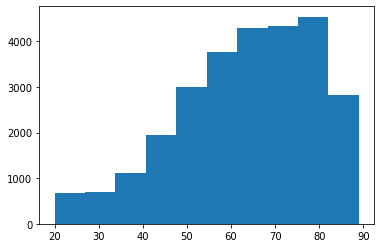

In [74]:
plt.hist(ages_20_to_90["age"].values)

# New Section

In [75]:
##TODO: Problem 4.3 - plot histogram for mortality rates

In [76]:
lab_df["age_floor"] = lab_df["age"] // 10

In [77]:
plot_data = lab_df.groupby(["age_floor"]).mean()["mort_hosp"]
plot_data

age_floor
1.0    0.065476
2.0    0.070031
3.0    0.082244
4.0    0.110184
5.0    0.119746
6.0    0.133029
7.0    0.157415
8.0    0.201030
Name: mort_hosp, dtype: float64

<BarContainer object of 8 artists>

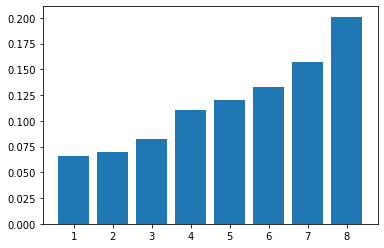

In [78]:
plt.bar(x = plot_data.index, height = plot_data)

In [79]:
##Problem 4.4 - retrain a model using C=1, penalty = l2 and evaluate AUC
##and accuracy on the test set with age less than 40 and on the test set with
##age greater than or equal to 40.

In [81]:
lab_df.drop(columns = ["age_floor"], inplace=True)

In [82]:
training_data = lab_df[lab_df["train"] == 1].drop(columns=["train", "test", "valid"])
validation_data = lab_df[lab_df["valid"] == 1].drop(columns=["train", "test", "valid"])
test_data = lab_df[lab_df["test"] == 1].drop(columns=["train", "test", "valid"])

In [83]:
print(len(training_data))
print(len(validation_data))
print(len(test_data))

16401
5448
5499


In [84]:
train_X, train_y = training_data.drop(columns=["mort_hosp"]), training_data["mort_hosp"]
valid_X, valid_y = validation_data.drop(columns=["mort_hosp"]), validation_data["mort_hosp"]

In [85]:
len(train_X.columns)

55

### Retrain the model

In [86]:
pipeline = Pipeline(
    [("num_standardizer", StandardScaler()),
     ("clf", LogisticRegression(solver='liblinear', 
                                C = 1, penalty = 'l2',
                                max_iter=2000, verbose=2))
     ]
)

In [87]:
pipeline.fit(train_X, train_y)

[LibLinear]

Pipeline(memory=None,
         steps=[('num_standardizer',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=2000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=2,
                                    warm_start=False))],
         verbose=False)

In [88]:
standardizer, model = pipeline["num_standardizer"], pipeline["clf"]

In [89]:
patients_less_than_40 = test_data[test_data["age"] < 40]
patients_more_than_40 = test_data[test_data["age"] >= 40]

In [90]:
print(f"Number of patients admitted below the age of 40 = {len(patients_less_than_40)}")
print(f"Number of patients admitted equal to and above 40 = {len(patients_more_than_40)}")

Number of patients admitted below the age of 40 = 492
Number of patients admitted equal to and above 40 = 5007


In [91]:
for data_df in [patients_less_than_40, patients_more_than_40]:
  features, labels = data_df.drop(columns=["mort_hosp"]), data_df["mort_hosp"]
  features_standardized = standardizer.transform(features)
  predictions = model.predict(features_standardized)
  print(f"min age = {data_df['age'].min()}, max age = {data_df['age'].max()}")
  print(f"model accuracy = {accuracy_score(labels, predictions)}")
  print(f"auc score = {roc_auc_score(labels, predictions)}")
  print()

min age = 16.0, max age = 39.0
model accuracy = 0.9410569105691057
auc score = 0.6101731601731601

min age = 40.0, max age = 89.0
model accuracy = 0.8589974036349112
auc score = 0.5653762801915481

